<a href="https://colab.research.google.com/github/AishaEvering/TensofFlow_ComputerVision_Practice/blob/main/Malaria_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.metrics import BinaryAccuracy
from google.colab import drive


In [62]:
ds, ds_info = tfds.load("malaria", with_info=True, split=['train[:80%]','train[80%:90%]','train[90%:]'], shuffle_files=True)
# ds, ds_info = tfds.load("malaria", with_info=True, shuffle_files=True)

In [56]:
# def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
#   TOTAL = len(dataset)

#   train_ds = dataset.take(int(TRAIN_RATIO * TOTAL))
#   val_ds = dataset.skip(int(TRAIN_RATIO * TOTAL)).take(int(VAL_RATIO * TOTAL))
#   test_ds = dataset.skip(int((TRAIN_RATIO+VAL_RATIO) * TOTAL))

#   return train_ds, val_ds, test_ds

In [57]:
# TRAIN_RATIO = 0.8
# VAL_RATIO = 0.1
# TEST_RATIO = 0.1

# train_ds, val_ds, test_ds = split(ds['train'], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [58]:
ds

{'train': <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [103]:
train_dataset = ds[0]
val_dataset = ds[1]
test_dataset = ds[2]

In [64]:
len(train_dataset), len(val_dataset), len(test_dataset)

(22046, 2756, 2756)

In [61]:
# len(train_ds), len(val_ds), len(test_ds)

(22046, 2755, 2756)

<ipython-input-74-0ff48a10ea9b>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(4,4,i+1)


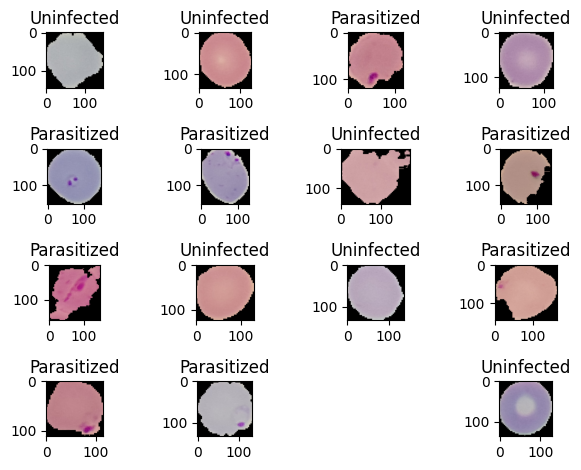

In [74]:
for i, sample in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(sample['image'])
  plt.title('Parasitized' if sample['label'] == 0 else 'Uninfected')
  plt.tight_layout()
  plt.grid(False)
  # plt.show()

In [96]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [101]:
def resize_rescale(data):
  return tf.image.resize(data['image'], (IMG_SIZE, IMG_SIZE))/255., data['label']

In [104]:
train_dataset = train_dataset.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [105]:
for img, lbl in train_dataset.take(1):
  print(img.shape, lbl)

(32, 224, 224, 3) tf.Tensor([0 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0], shape=(32,), dtype=int64)


## Model Creation

In [142]:
model = tf.keras.Sequential([ # following the LeNet architecture
                              InputLayer(shape=(IMG_SIZE,IMG_SIZE, 3)),
                              Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
                              BatchNormalization(),
                              MaxPool2D(pool_size=2, strides=2),
                              Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
                              BatchNormalization(),
                              MaxPool2D(pool_size=2, strides=2),
                              Flatten(),
                              Dense(100, activation = 'relu'),
                              BatchNormalization(),
                              Dense(10, activation = 'relu'),
                              BatchNormalization(),
                              Dense(1, activation = 'sigmoid')
], name = 'malaria-model')
model.summary()

Model: "malaria-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [143]:
model.compile(
    optimizer = Adam(learning_rate=0.01),
    loss = BinaryCrossentropy(),
    metrics = [BinaryAccuracy()],
)

In [119]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1
)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - binary_accuracy: 0.6850 - loss: 0.5724 - val_binary_accuracy: 0.6223 - val_loss: 1.5535
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - binary_accuracy: 0.9199 - loss: 0.2234 - val_binary_accuracy: 0.9057 - val_loss: 0.2794
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - binary_accuracy: 0.9389 - loss: 0.1791 - val_binary_accuracy: 0.9285 - val_loss: 0.2318
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - binary_accuracy: 0.9221 - loss: 0.2126 - val_binary_accuracy: 0.9358 - val_loss: 0.1877
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - binary_accuracy: 0.9485 - loss: 0.1536 - val_binary_accuracy: 0.5697 - val_loss: 0.9901
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - binary_accuracy: 0.9529 - loss: 0.1438 - val_binary_accuracy: 0.9394 - val_loss: 0.2968
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - binary_accuracy: 0.9530 - loss: 0.1411 - val_binary_accuracy: 0.7286 - val_loss:

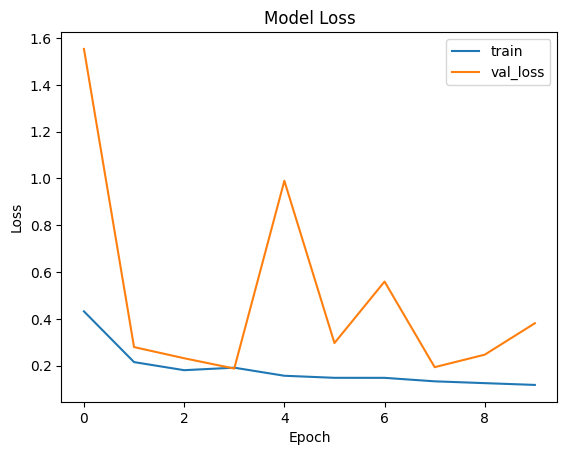

In [120]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['train','val_loss'])
plt.show()

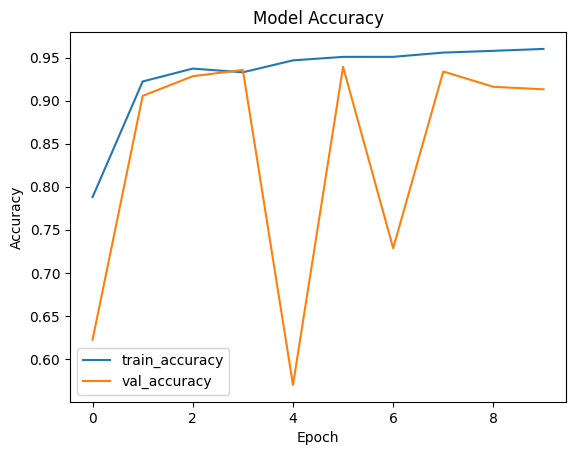

In [121]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

In [122]:
model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - binary_accuracy: 0.9280 - loss: 0.3281


[0.32736432552337646, 0.9259796738624573]

In [124]:
def parasite_or_not(x):
  if x<0.5:
    return str('P')
  else:
    return str('U')

In [128]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


'U'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


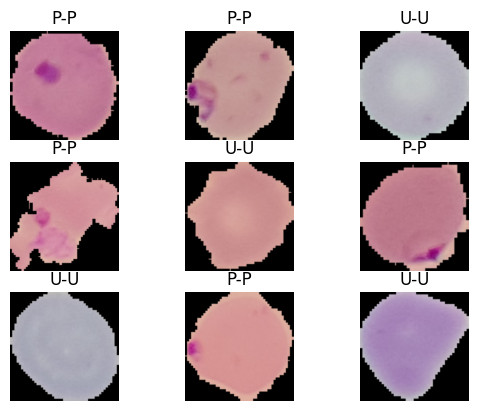

In [131]:
for image, label in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[i])
    plt.title(parasite_or_not(label.numpy()[i]) + "-" + parasite_or_not(model.predict(image)[i][0]))
    plt.axis('off')

## Loading and Saving

In [133]:
model.save('LenetSavedModel.h5')

In [141]:
lenet_loaded_model = tf.keras.models.load_model('LenetSavedModel.h5')
lenet_loaded_model.summary()

Model: "malaria-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,299 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


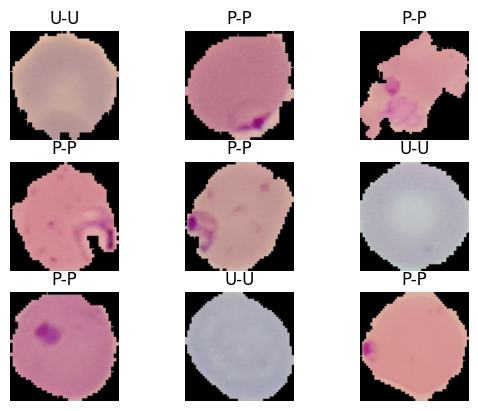

In [135]:
for image, label in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[i])
    plt.title(parasite_or_not(label.numpy()[i]) + "-" + parasite_or_not(lenet_loaded_model.predict(image)[i][0]))
    plt.axis('off')

In [136]:
lenet_loaded_model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - binary_accuracy: 0.9282 - loss: 0.3271


[0.32736435532569885, 0.9259796738624573]

In [140]:
import os

os.makedirs('weights', exist_ok=True)

model.save_weights("weights/lenet.weights.h5")

In [145]:
model.load_weights('/content/weights/lenet.weights.h5')
model.evaluate(test_dataset)

 3/87 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - binary_accuracy: 0.9740 - loss: 0.1270

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - binary_accuracy: 0.9283 - loss: 0.3260


[0.32736435532569885, 0.9259796738624573]

## Saving to Google Drive


In [147]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [148]:
!cp "/content/LenetSavedModel.h5" "/content/drive/MyDrive/Udemy/Computer Vision/"

In [149]:
os.makedirs('lenet_colab', exist_ok=True)
!cp "/content/drive/MyDrive/Udemy/Computer Vision/LenetSavedModel.h5" 'lenet_colab'